# Compute the style of an image

Based on the paper by Gatis et al. 2016 ([ref](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)).


In [1]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Get images

(-0.5, 499.5, 727.5, -0.5)

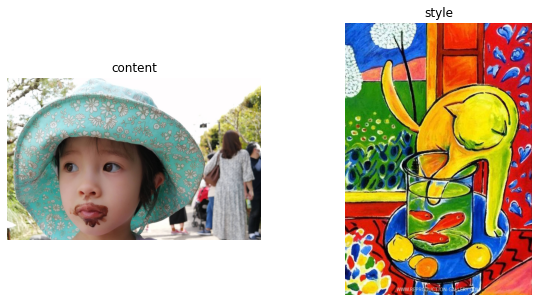

In [2]:
# content_im = skimage.data.coffee()
content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/Cecile2.jpg?raw=true")
style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/matisse_cat.jpeg?raw=true")



fig, ax = plt.subplots(1,2,figsize=[10,5])
plt.sca(ax[0])
_ = plt.imshow(content_im); plt.title("content"); plt.axis("off")
plt.sca(ax[1])
_ = plt.imshow(style_im); plt.title("style"); plt.axis("off")

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [3]:
# From D2L
im_shape = (150, 225)
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

# Get a pretrained model

In [4]:
pretrained_net = torchvision.models.vgg11(pretrained=True)

In [5]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Defined the image generator network and a function to make a partial pass through the network

In [21]:
class ImageGenerator(nn.Module):
    def __init__(self,image):
        super(ImageGenerator,self).__init__()
        # self.im = nn.Parameter(torch.rand(1, 3, *shape))
        self.im = nn.Parameter(torch.rand(image.shape)+image)
    def forward(self):
        return self.im

In [7]:
# Apply layer by layer mods
def partial_forward(input_im,n_layer):
    X = input_im
    for il in range(n_layer):
        X = pretrained_net.features[il](X)
    return X

def visu_im_rep(X, ncol=5):
    nrow = int(np.ceil(n_channels/ncol))
    fig, ax = plt.subplots(nrow,ncol,figsize=[15,24],tight_layout=True)
    with torch.no_grad():
        for ic in range(n_channels):
            plt.sca(ax[np.unravel_index(ic,(nrow,ncol))])
            show_image(X[0,ic,:,:])

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

In [8]:
# len(pretrained_net.features)
pretrained_net.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, 

# Compute style

In [9]:


def get_feature_maps(image, layer_list):
#      return [pretrained_net.features[il](image) for il in range (layer_list[-1]+1) if (il in layer_list) ]
    a = image 
    feature_maps = []
    for il in range(layer_list[-1]+1):
#         a = pretrained_net.features[il](a)
        a = net[il](a)
        if (il in layer_list):
            feature_maps.append(a)
    return feature_maps

def get_gram(feature_maps):
    gram_matrices = []
    for a in feature_maps:
        fac = 1./(2.*a.shape[1]*a.shape[2]*a.shape[3])
        a = a.reshape(a.shape[1],-1) 
        gram_matrices.append(torch.matmul(a,a.T)*fac)

    return gram_matrices

def get_style_loss(gram_style_image, gram_generated_image):
    loss = 0
    for A, G in zip(gram_style_image,gram_generated_image):
        loss += torch.sum((A-G)**2)
    return loss

def get_content_loss(feature_map_content, feature_map_gen):
    loss = 0
    for i in range(len(feature_map_content)):
         loss += torch.mean((feature_map_content[i]-feature_map_gen[i])**2)
    return loss


In [10]:
def get_TV_loss(im):
    # y: filtered representation of content image on the given layer of the NN
    # y_hat: same as y for generated image
    # im: the generated image
    
    beta = 1. # Can be between 1 and 2
    H = im.shape[2]
    W = im.shape[3]
    C = im.shape[1]
    sigma = torch.sqrt(torch.sum(im**2))/H/W/C
    B = 1. # because images are standardized
    a = 0.01 # 1%
    Lambda_b = sigma**beta / (H*W*(a*B)**beta)# There is a better definition in the paper
    
    # total variation
    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    d_dx = .5*(d_dx[:,:,:,1:]+d_dx[:,:,:,:-1])
    d_dy = .5*(d_dy[:,:,1:,:]+d_dy[:,:,:-1,:])
    TV = torch.sum((d_dx**2+d_dy**2)**(beta/2.))
#     print(f"MSE: {loss:.2e}, TV: {TV:.2e}, $\\lambda$ TV: {Lambda_b*TV:.2e}")
    loss = Lambda_b*TV
    return loss

# Initialize GPU if available

In [11]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Train

In [24]:
im_gen = ImageGenerator(preprocess(content_im, im_shape)).to(device)
im_style = preprocess(style_im, im_shape).to(device)
im_content = preprocess(content_im, im_shape).to(device)

optimizer = torch.optim.LBFGS(im_gen.parameters(),line_search_fn='strong_wolfe')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5)
# optim = torch.optim.Adam(im_gen.parameters())
# Stopping criterion
abs_loss_limit = 1e-10
rel_loss_limit = 1e-12


# layer_list = [8,17, 26, 35]
# layer_list = [0,1,2,3,4,5]
# style_layer_list = [8,17, 26, 35]
style_layer_list = [7, 9, 12, 14, 17, 19]
content_layer = [9]

net = nn.Sequential(*[
    pretrained_net.features[i]
    for i in range(max(content_layer + style_layer_list) + 1)]).to(device)

with torch.no_grad():
    fm_style = get_feature_maps(im_style, style_layer_list)
    fm_content = get_feature_maps(im_content, content_layer)
    gram_style = get_gram(fm_style)
content_weight = 0.01
style_weight = 1.0
tv_weight = 1.0


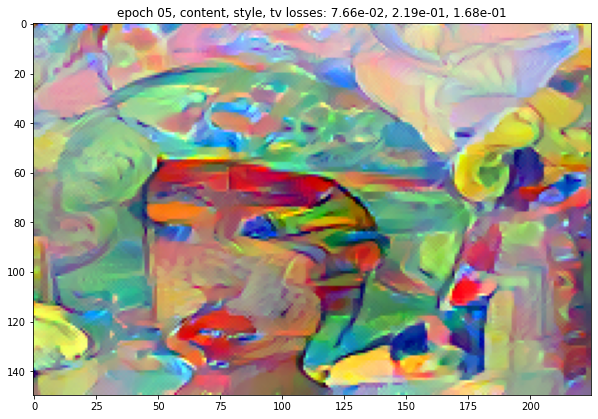

In [ ]:
# train
fig, ax = plt.subplots(1,1,figsize=[10,10])

def closure_small():

    im_generated = im_gen()
    # fm_style = get_feature_maps(im_style.detach(), style_layer_list)
    # gram_style = get_gram(fm_style)
    fm_gen_style = get_feature_maps(im_generated, style_layer_list)
    fm_gen_content = get_feature_maps(im_generated, content_layer) # having to go through the network again is a bit ugly
    gram_gen = get_gram(fm_gen_style)
    content_loss = get_content_loss(fm_content, fm_gen_content)
    
    style_loss = get_style_loss(gram_style,gram_gen)
    tv_loss = get_TV_loss(im_generated)
    
    return content_loss, style_loss, tv_loss
def closure():
    optimizer.zero_grad()
    content_loss, style_loss, tv_loss = closure_small()
    loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss
    # print(f"content, style, tv losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}")
    loss.backward()
    return loss

last_loss = 1e10
for i in range(10000):    
#     im_generated = im_gen()
    optimizer.step(closure)
    # scheduler.step()
    # adjust weights
    if i%5==0:
        with torch.no_grad():
            content_loss, style_loss, tv_loss = closure_small()
            loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss
            if tv_weight*tv_loss>0.2*(style_weight*style_loss) or tv_weight*tv_loss>0.2*content_weight*content_loss:
                tv_weight *= 0.75
            imnew = postprocess(im_gen())
            ax.cla()
            plt.imshow(imnew)
            plt.title(f"epoch {i:02d}, content, style, tv losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}")
            clear_output(wait = True)
            display(fig)

            


            if loss<abs_loss_limit:
                clear_output(wait = True)
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss)<rel_loss_limit:
                clear_output(wait = True)
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break
                
            last_loss = loss

In [ ]:
content_weight